In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline

In [38]:
# Standard Parameters
test_set_size = 0.2 # 0.2, 0.6, 0.8
randomized_labels = False
mislabel_percentage = 100.0 #percentage decimals numbers: 0-100. 
standardize = True
apply_pca = True
apply_anova = False
feature_variance_threshold = 0.0

In [39]:
# Load data
file_path_data = "TCGAdata.txt"
file_path_labels = "TCGAlabels.txt"
df_data = pd.read_csv(file_path_data, delim_whitespace=True, header=0, quotechar='"')
df_labels = pd.read_csv(
    file_path_labels, delim_whitespace=True, header=0, quotechar='"'
)
df = pd.merge(df_data, df_labels, left_index=True, right_index=True, how="left")

In [40]:
# Print all unique labels in the last column of df
print(df.iloc[:, -1].unique())

['GBM' 'BC' 'OV' 'LU' 'KI' 'U']


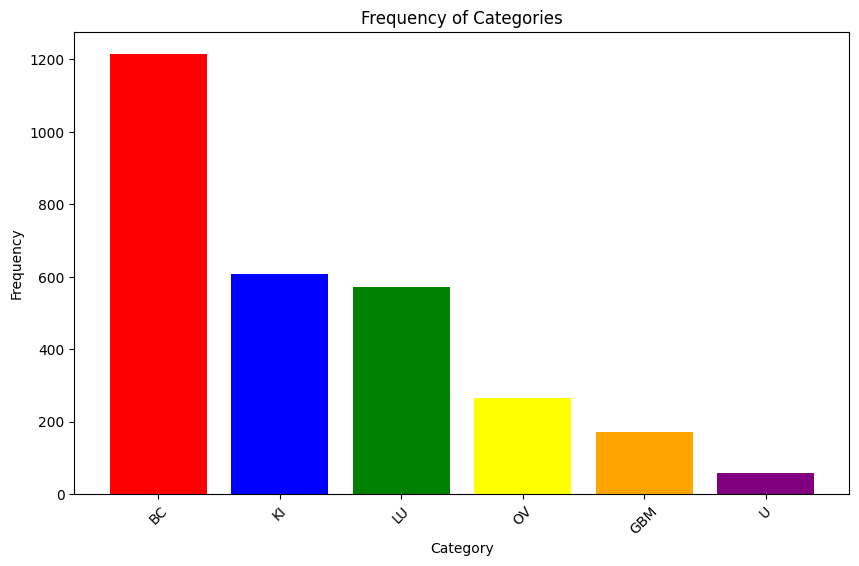

In [41]:
# Count the occurrences of each category
category_counts = df.iloc[:, -1].value_counts()
category_counts_list=category_counts.tolist()
# Create a dictionary to map each class to a color
class_colors = {'BC': 'red', 'KI': 'blue', 'LU': 'green', 'OV': 'yellow', 'GBM': 'orange', 'U': 'purple'}

# Create a list of colors for each bar using the mapped colors
colors = [class_colors.get(category, 'gray') for category in category_counts.index]

# Create a bar chart with unique colors
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values, color=colors)

# Add labels and title if needed
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Frequency of Categories')
#plt.legend(category_counts_list, title='Frequency', loc='upper right')
# Adjust the xticks if they are overlapping
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [42]:
# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=20),
}

In [43]:
# Create a df for every x
df_BC = df[df["x"] == "BC"]
df_KI = df[df["x"] == "KI"]
df_LU = df[df["x"] == "LU"]
df_OV = df[df["x"] == "OV"]
df_GBM = df[df["x"] == "GBM"]
df_U = df[df["x"] == "U"]

In [44]:
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]  # Labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_set_size, random_state=42
)

In [45]:
##### Section for mislabelling a percentage of y_test #####
# Function to mislabel a percentage of the data
def randomize_labels(labels, percentage):
    n_total = len(labels)
    n_change = int(n_total * (percentage / 100))
    indices_to_change = np.random.choice(n_total, n_change, replace=False)
    #print(n_total)

    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Mislabeling logic
    new_labels = labels.copy()
    for index in indices_to_change:
        original_label = labels.iloc[index]
        possible_labels = unique_labels[unique_labels != original_label]
        new_labels.iloc[index] = np.random.choice(possible_labels)
    return new_labels, indices_to_change

def cross_val_pca(classifier):
    # Define the cross-validation and the range of components to test
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    component_range = range(1, 30)  # Up to 50 components, for example

    # Store average scores for each number of components
    scores = []

    for n_components in component_range:
        # Create a PCA object with the current number of components
        pca = PCA(n_components=n_components)
        
        # Create a logistic regression classifier
        #classifier = LogisticRegression(max_iter=10000)  # Increase max_iter
        
        # Make a pipeline combining PCA and the classifier
        pipeline = make_pipeline(pca, classifier)
        
        # Perform cross-validation and store the average score
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, verbose = 1)
        scores.append(np.mean(cv_scores))

    # Find the number of components with the highest average score
    optimal_components = component_range[np.argmax(scores)]

    print(f"Optimal number of components: {optimal_components}, Validation error: {scores[optimal_components]}")

    return optimal_components

In [46]:
# Randomizing labels in y_test
if randomized_labels:
    y_train_randomized, indices_change = randomize_labels(y_train, percentage=mislabel_percentage)
    y_train=y_train_randomized
    print("Successful randomization of labels")

In [47]:
if standardize:
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

if apply_anova:
    # TODO: NOT DONE
    sel = VarianceThreshold(threshold=feature_variance_threshold)
    X_train = sel.fit_transform(X_train)
    X_test = sel.transform(X_test)

if apply_pca:
    best_components = {name: (0, 0) for name in classifiers}
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Find best components
    # Change X_train to X_train_scaled
    for name, clf in classifiers.items():
        best_score = 0
        for components in range(10, 21):
            pca = PCA(n_components=components)
            X_train_pca = pca.fit_transform(X_train)
            cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=kf)
            mean_cv_score = np.mean(cv_scores)
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_components[name] = (components, best_score)
        
        # Print out the best number of principal components for each classifier
        print(f"The best number of principal components for {name} is {best_components[name][0]} with a score of {best_components[name][1]}.")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

The best number of principal components for Logistic Regression is 20 with a score of 0.9956691175780114.
The best number of principal components for Random Forest is 17 with a score of 0.987874092646327.
The best number of principal components for KNN is 19 with a score of 0.9904733733367138.


Validation score: 0.9956691175780114


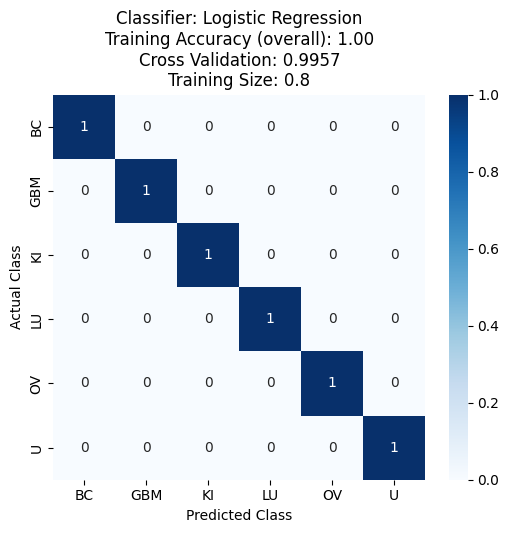

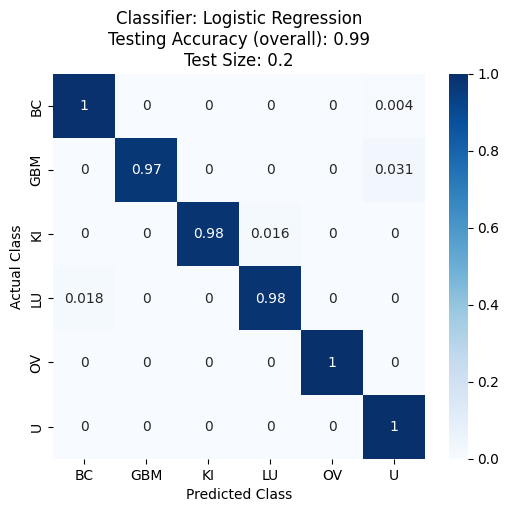

Logistic Regression: 0.9896193771626297
Validation score: 0.9874393141204421


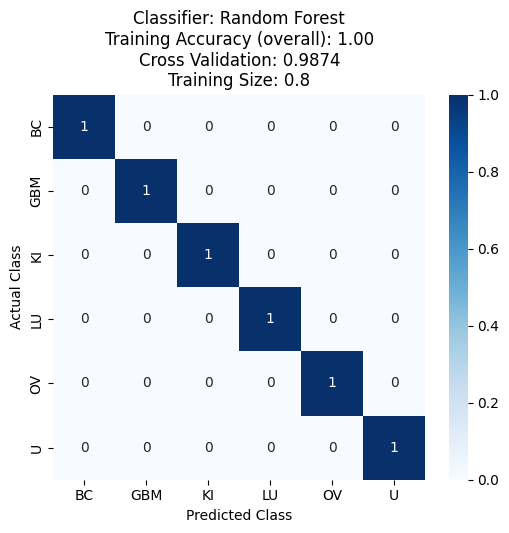

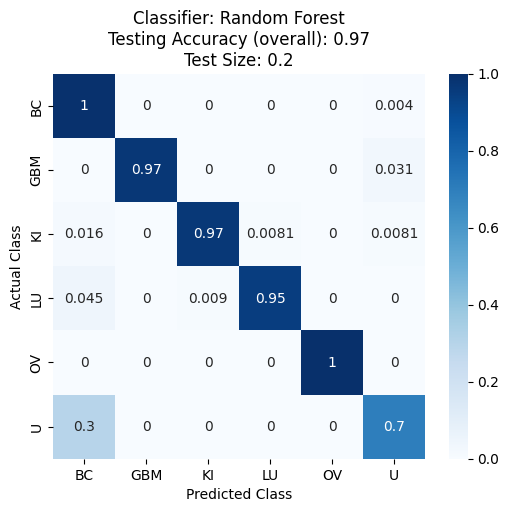

Random Forest: 0.9740484429065744
Validation score: 0.9904733733367138


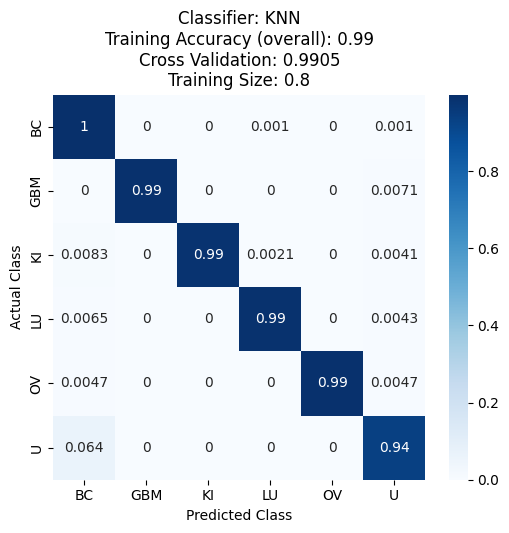

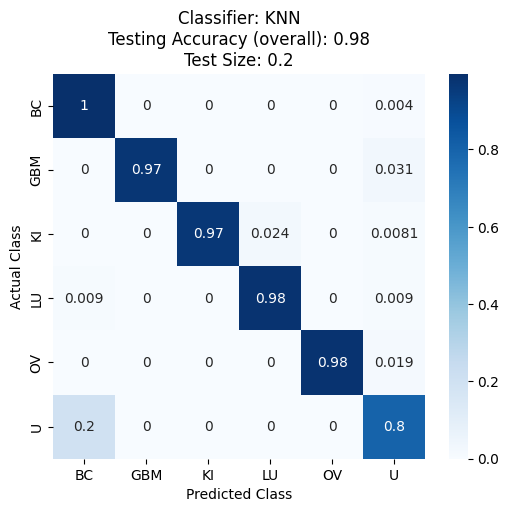

KNN: 0.9809688581314879


In [48]:
for name, clf in classifiers.items():
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    if apply_pca:
        pca = PCA(n_components=best_components[name][0])
        X_train_copy = pca.fit_transform(X_train_copy)
        X_test_copy = pca.transform(X_test_copy)
        
    ### Training Score###
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, X_train_copy, y_train, cv=kf)
    clf.fit(X_train_copy, y_train)
    y_pred_train = clf.predict(X_train_copy)
    accuracy = accuracy_score(y_train, y_pred_train) 
    cm = confusion_matrix(y_train, y_pred_train, normalize="true")
    class_labels = sorted(set(y_train)) 
    print(f"Validation score: {np.mean(cv_scores)}") 
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Classifier: {name}\nTraining Accuracy (overall): {accuracy:.2f}\nCross Validation: {np.mean(cv_scores):.4f}\nTraining Size: {(1-test_set_size):.1f}')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    
    ### Test score #### 
    y_pred_test = clf.predict(X_test_copy)
    accuracy = accuracy_score(y_test, y_pred_test)
    cm = confusion_matrix(y_test, y_pred_test, normalize="true")
    class_labels = sorted(set(y_test)) 
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Classifier: {name}\nTesting Accuracy (overall): {accuracy:.2f}\nTest Size: {test_set_size}')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    
    plt.show()

    print(f"{name}: {accuracy}")